In [3]:
# Data Manipulation
import numpy as np
import pandas as pd
# Visualisation
import matplotlib.pyplot as plt
# Dataset exploring
import os
# Dataset generation
from keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
# Transfert learning
from keras.applications import *
# Optimizer
from keras.optimizers import *
# Keras layers
from keras.layers import *
# Keras model
from keras.models import Model

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as k
import keras

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [6]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command

/content/gdrive/My Drive/Kaggle


In [7]:
pwd

'/content/gdrive/My Drive/Kaggle'

In [ ]:
!kaggle datasets download -d sriramr/fruits-fresh-and-rotten-for-classification

fruits-fresh-and-rotten-for-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
!ls

dataset		       fruits-fresh-and-rotten-for-classification.zip
fruit_classifier.h5    kaggle.json
fruit_classifier.hdf5


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Archive:  fruits-fresh-and-rotten-for-classification.zip
replace dataset/dataset/test/freshapples/Screen Shot 2018-06-08 at 4.59.44 PM.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
classes = []
class_counter = 0

for dirname, _, filenames in os.walk('/content/gdrive/My Drive/Kaggle/dataset/train/'):
    if dirname.endswith('/'):
        continue
    else:
        classes.append({dirname.split('/')[-1]: 0})
    file_count = 0
    for filename in filenames:
        file_count += 1
    classes[class_counter][dirname.split('/')[-1]] = file_count
    class_counter += 1
    
print('{:<15} {:<15}'.format('Class', 'Number of instances'))
print()
for d in classes:
    [(k, v)] = d.items()
    print('{:<15} {:<15}'.format(k, v))

Class           Number of instances

freshapples     1693           
freshbanana     1581           
freshoranges    1466           
rottenapples    2342           
rottenbanana    2224           
rottenoranges   1595           


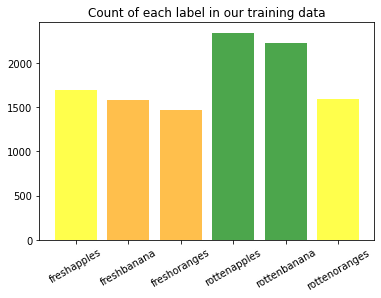

In [ ]:
counts = []
labels = []
for d in classes:
    [(k, v)] = d.items()
    labels.append(k)
    counts.append(v)

plt.figure()
plt.bar(range(len(counts)), counts, color = ['yellow', 'orange', 'orange', 'green', 'green', 'yellow'], alpha = .7)
plt.xticks(range(len(counts)), labels, rotation = 30)
plt.title('Count of each label in our training data')
plt.show()

In [ ]:
from tensorflow import keras

base_model = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# Freeze base model
base_model.trainable = False

In [ ]:
from keras.models import Model
from keras.layers import *

# Create inputs with correct shape
inputs = Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)

# Add pooling layer or flatten layer
x = Flatten()(x)

# Add a hidden layer
x = Dense(256, activation='relu')(x)

# Add a dropout layer
x = Dropout(.5)(x)

# Add final dense layer
outputs = Dense(6, activation = 'softmax')(x)

# Combine inputs and outputs to create model
model = Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1542      
Total params: 21,139,014
Trainable params: 6,424,326
Non-trainable params: 14,714,688
_________________________________________

In [ ]:
model.compile(loss='categorical_crossentropy',
              metrics=["accuracy"],
             optimizer = 'nadam')

In [47]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

transformation_ratio = 0.05

datagen = ImageDataGenerator(rescale=1. / 255,
                             validation_split = 0.2,
                             rotation_range=transformation_ratio,
                             shear_range=transformation_ratio,
                             zoom_range=transformation_ratio,
                             cval=transformation_ratio,
                             horizontal_flip=True,
                             vertical_flip=True)

In [48]:
# load and iterate training dataset
train_it = datagen.flow_from_directory("/content/gdrive/My Drive/Kaggle/dataset/train", 
                                       target_size=(224,224), 
                                       color_mode='rgb', 
                                       class_mode="categorical",
                                       batch_size=12,
                                       subset = "training")

# Validation Data
val_it = datagen.flow_from_directory("/content/gdrive/My Drive/Kaggle/dataset/train",
                                     target_size=(224,224),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=12,
                                     subset='validation')

# load and iterate test dataset
test_it = datagen.flow_from_directory("/content/gdrive/My Drive/Kaggle/dataset/test", 
                                      target_size=(224,224), 
                                      color_mode='rgb', 
                                      class_mode="categorical")

Found 8723 images belonging to 6 classes.
Found 2178 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


In [ ]:
history = model.fit_generator(generator = train_it,
                              steps_per_epoch=train_it.samples/train_it.batch_size,
                              epochs=16,
                              validation_data=val_it,
                              valid+ation_steps=test_it.samples/test_it.batch_size,
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/16
726/726 [==============================] - 3010s 4s/step - loss: 0.6461 - accuracy: 0.7521 - val_loss: 0.2372 - val_accuracy: 0.9157
Epoch 2/16
726/726 [==============================] - 346s 477ms/step - loss: 0.4418 - accuracy: 0.8326 - val_loss: 0.1276 - val_accuracy: 0.9608
Epoch 3/16
726/726 [==============================] - 262s 361ms/step - loss: 0.3791 - accuracy: 0.8511 - val_loss: 0.1094 - val_accuracy: 0.9627
Epoch 4/16
726/726 [==============================] - 193s 265ms/step - loss: 0.3198 - accuracy: 0.8756 - val_loss: 0.0937 - val_accuracy: 0.9618
Epoch 6/16
726/726 [==============================] - 180s 248ms/step - loss: 0.3074 - accuracy: 0.8770 - val_loss: 0.0887 - val_accuracy: 0.9686
Epoch 7/16
726/726 [==============================] - 176s 242ms/step - loss: 0.2931 - accuracy: 0.8858 - val_loss: 0.0966 - val_accuracy: 0.9588
Epoch 8/16
726/726 [==============================] - 168s 231ms/step - loss: 0.2725 - accuracy: 0.8906 - val_loss: 0.0850 - v

In [ ]:
!nvidia-smi

Mon Dec 21 18:46:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    32W /  70W |   8807MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Evaluating model

In [ ]:
import matplotlib.pyplot as plt

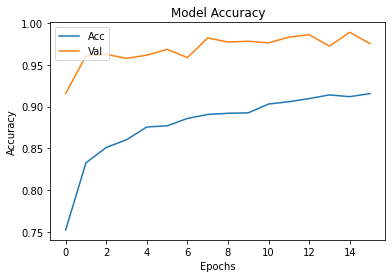

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Acc','Val'], loc = 'upper left')


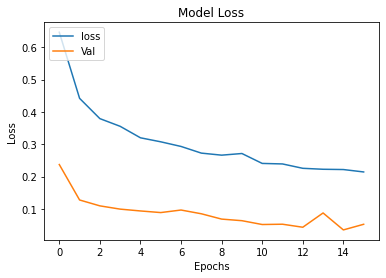

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss','Val'], loc = 'upper left')

In [ ]:
model.evaluate(test_it, steps=test_it.samples/test_it.batch_size)

84/84 [==============================] - 850s 10s/step - loss: 0.0714 - accuracy: 0.9755


[0.0714406967163086, 0.9755374193191528]

In [ ]:
model.save('./fruit_classifier.h5')

In [ ]:
model.save('./fruit_classifier.hdf5')

In [9]:
from keras.models import Model, load_model

In [10]:
new_model=load_model('./fruit_classifier.h5')

In [101]:
new_model1=load_model('./fruit_classifier_org.h5')

In [29]:
from tqdm import tqdm
import cv2
from random import shuffle

In [41]:
def load_rottenvsfresh_valset():
    quality=['fresh', 'rotten']
    X,Y=[],[]
    z=[]
    for cata in tqdm(os.listdir('/content/gdrive/My Drive/Kaggle/dataset/test')):
        if quality[0] in cata:
            path_main=os.path.join('/content/gdrive/My Drive/Kaggle/dataset/test',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(224,224))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,0])
        else:
            path_main=os.path.join('/content/gdrive/My Drive/Kaggle/dataset/test',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(224,224))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,1])
    print('Shuffling your data.....')
    shuffle(z)
    for images, labels in tqdm(z):
        X.append(images);Y.append(labels)
    return X,Y   

In [42]:
X_val,Y_val=load_rottenvsfresh_valset()

100%|██████████| 2698/2698 [00:00<00:00, 1141324.48it/s]

Shuffling your data.....


In [39]:
Y_val=np.array(Y_val)
X_val=np.array(X_val)
y_ser=pd.Series(Y_val)
y_ser.value_counts()

1    1534
0    1164
dtype: int64

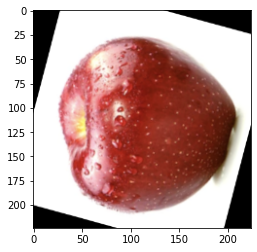

In [127]:
plt.imshow(X_val[10])

In [103]:
new_model1.evaluate(test_it, steps=test_it.samples/test_it.batch_size)

84/84 [==============================] - 40s 471ms/step - loss: 0.0922 - accuracy: 0.9681


[0.09224318712949753, 0.968124508857727]

In [128]:
new_model1.predict(X_val[10].reshape(1,224,224,3))

array([[1., 0., 0., 0., 0., 0.]], dtype=float32)